# BIS(BIOPROCESS ASSISTANT SOFTWARE)

## BIBLIOTECAS:

In [1]:
import pandas as pd
import numpy as np
from numpy import prod  # Substituir a importação
from lmfit import Model
import lmfit
import matplotlib.pyplot as plt
import pprint
import funcoes as fn

## IMPORTANTO E TRABALHANDO COM OS DADOS:

### Importando arquivos de exemplo:

In [2]:
# Defina o caminho para o arquivo .xlsx
caminho_arquivo = '/home/ABTLUS/daniel23020/Documentos/ILUM/4° Semestre/IP/BAS/dados_exemplo/GP_example_Ilum.xlsx'

dataset_exemplo = pd.read_excel(caminho_arquivo, header=None)

In [3]:
dataset_exemplo.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,0.0,0.318,0.212,0.244,0.198,0.203,0.224,0.192,0.166,0.137,...,0.228,0.189,0.217,0.178,0.138,0.116,0.082,0.051,0.051,0.079
1,30.0,0.376,0.249,0.297,0.243,0.243,0.271,0.240,0.201,0.172,...,0.273,0.228,0.257,0.205,0.150,0.124,0.083,0.047,0.047,0.073
2,60.0,0.407,0.269,0.327,0.263,0.265,0.287,0.257,0.219,0.184,...,0.295,0.247,0.275,0.228,0.160,0.131,0.089,0.046,0.048,0.071
3,90.0,0.443,0.292,0.355,0.281,0.284,0.309,0.274,0.227,0.194,...,0.320,0.270,0.302,0.247,0.167,0.137,0.094,0.047,0.047,0.075
4,120.0,0.484,0.315,0.384,0.312,0.314,0.333,0.295,0.247,0.213,...,0.340,0.298,0.322,0.264,0.171,0.138,0.096,0.047,0.048,0.075


### Função: Tira média das triplicatas na horizontal e adiciona um nome a cada coluna.

In [4]:
def df_triplicatas(dataset):

    dataset_sem_triplicatas = pd.DataFrame(dataset.iloc[:,0]) # Reservando a primeira coluna do dataset, correspondente ao tempo. 

    dataset_sem_triplicatas.columns = ['Tempo(horas)'] + list(dataset_sem_triplicatas.columns[1:])  # Substitua 'Novo_Nome' pelo nome desejado

    # Divide os valores da primeira coluna por 60
    dataset_sem_triplicatas["Tempo(horas)"] = dataset_sem_triplicatas["Tempo(horas)"] / 60 #transformando o tempo de minutos para hora


    colunas = int((len(dataset.columns) - 1) / 3)

    letras_colunas = ["A","B","C","D","E","F","G","H",]

    letra = 0

    passo = 1

    for i in range(1, colunas + 1):
        
        colunas_para_media = dataset.iloc[:, (i*3 -2) : (i*3+1)]  # Substitua 0:3 pelos índices das colunas desejadas

        # Calcula a média das três colunas para cada linha
        media_colunas = colunas_para_media.mean(axis=1)

        # Cria um novo DataFrame e adiciona a coluna com as médias
        dataset_sem_triplicatas[f'Poço-{letras_colunas[letra]}({(passo*3-2)}-{(passo*3)})'] = media_colunas

        if (i % 12) == 0:
            letra += 1
            
        
        if passo == 4:
            passo = 1
        else:
            passo += 1

    return dataset_sem_triplicatas
    

In [5]:
def criar_dici_triplicatas(dataset):
    dici_triplicatas = {}
    tempo_coluna = dataset.columns[0]  # A primeira coluna é "Tempo(horas)"
    num_colunas_poço = 3  # Número de colunas por poço
    letras_colunas = ["A", "B", "C", "D", "E", "F", "G", "H"]

    for letra_idx, letra in enumerate(letras_colunas):
        for i in range(0, 12, num_colunas_poço):
            # Nome da chave no formato "Poço_X(n-m)"
            chave = f"Poço_{letra}({i+1}-{i+num_colunas_poço})"

            # Pegando a coluna "Tempo(horas)" e as 3 colunas consecutivas do poço
            colunas_poço = [tempo_coluna] + [f"Poço_{letra}({i+j+1})" for j in range(num_colunas_poço)]
            dici_triplicatas[chave] = dataset[colunas_poço]

    return dici_triplicatas


## Criando Dicionário de Datasets com base nas colunas:

### Criando uma dicionário de datasets

In [6]:
def construir_dici_poços(dataset):
    """Função que através de um dataset dado constrói um dicionario de datasets além disso modifica o nome da segunda coluna do dataset para "y_experimental".

    Args:
        dataset: Um dataset qualquer

    Returns:
        dici: Dicionário no qual cada chave é um poço e os valores são um dataset contenco as colunas "Tempo(horas)" e "y_esperimental"
    """
    primeira_coluna = dataset.columns[0]

    # Criando o dicionário com as colunas (exceto a primeira) e renomeando a segunda coluna para "y_ori"
    return {
        col: dataset[[primeira_coluna, col]].rename(columns={col: "y_experimental"}) 
        for col in dataset.columns[1:]
    }

### Criando um dicionário de dicionario de datasets

In [7]:
def construir_dici_placas(arquivos):
    dici_placas = {}
    for i, dic in enumerate(arquivos, start=1):
        # Cria a chave "Placa_{i}" e atribui o dicionário de poços
        dici_placas[f"Placa_{i}"] = dic
    
    return dici_placas

In [8]:
def arquivos_to_placas(dados_brutos):
    """
    Constrói um dicionário de placas a partir de uma lista de dicionários de poços.

    :param arquivos: Lista de dicionários de poços
    :return: Dicionário de placas organizado
    """
    
    lista_df_destriplicados = []

    for dados in dados_brutos: 
        df_reduzido = df_triplicatas(dados)
        lista_df_destriplicados.append(df_reduzido)

    lista_dici_poços = []

    for df in lista_df_destriplicados:
        dici_poços = construir_dici_poços(df)
        lista_dici_poços.append(dici_poços)
    

    dici_placas = construir_dici_placas(lista_dici_poços)

    return dici_placas


In [9]:
dados_brutos = [dataset_exemplo]

In [10]:
df_com, df_sem = fn.arquivos_to_placas(dados_brutos)

In [11]:
teste = pd.DataFrame(df_sem)

In [12]:
df_sem["Placa_1"]["Poço_A(1-3)"]

,Tempo(horas),y_experimental
0,0.000000,0.258000
1,0.500000,0.307333
2,1.000000,0.334333
3,1.500000,0.363333
4,2.000000,0.394333
...,...,...
235,117.504167,8.317333
236,118.004167,8.328000
237,118.504167,8.330333
238,119.004167,8.363333


## Modelagem Matemática

### Definindo Variáveis:

In [13]:
placa = "Placa_1"
poços = "Poço_A(1-3)"

In [14]:
df_sem["Placa_1"]["Poço_A(1-3)"]

,Tempo(horas),y_experimental
0,0.000000,0.258000
1,0.500000,0.307333
2,1.000000,0.334333
3,1.500000,0.363333
4,2.000000,0.394333
...,...,...
235,117.504167,8.317333
236,118.004167,8.328000
237,118.504167,8.330333
238,119.004167,8.363333


In [15]:
x = df_sem[placa][poços]["Tempo(horas)"]
y = df_sem[placa][poços]["y_experimental"]

#Método Antigo
#y = dicionario_poços[dados][dicionario_poços[dados].columns[1]] 
#x = dicionario_poços[dados][dicionario_poços[dados].columns[0]] 

### Definindo Modelo de Gompertz:

In [16]:
def gompertz(t, Nmax, k, tlag):
    '''
    Calcula a função de Gompertz para modelar o crescimento microbiano.

    Args:
    t (float): Tempo em unidades de horas.
    Nmax (float): Valor assintótico máximo da população de micro-organismos. Representa a capacidade máxima de crescimento da cultura.
    k (float): Taxa de crescimento específica. Determina a rapidez com que a população de micro-organismos cresce após o período de lag.
    tlag (float): Tempo de lag ou atraso antes do início do crescimento exponencial. Representa o tempo necessário para a adaptação inicial da população.

    Returns:
    float: Resultado da função de Gompertz, o valor estimado da população de micro-organismos para cada instante de tempo.
    '''
    return Nmax * np.exp(-np.exp(-k * (t - tlag)))

In [17]:
modelo_gompertz = Model(fn.gompertz)

params = modelo_gompertz.make_params(Nmax=10, k=0.5, tlag=1)

resultado_fit = modelo_gompertz.fit(y, params, t=x)

residuos = y - resultado_fit.best_fit

# Calcula o desvio padrão dos resíduos
desvio_padrao = np.std(residuos)

print(resultado_fit.fit_report())

[[Model]]
    Model(gompertz)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 240
    # variables        = 3
    chi-square         = 3.79806044
    reduced chi-square = 0.01602557
    Akaike info crit   = -989.075615
    Bayesian info crit = -978.633698
    R-squared          = 0.99752305
[[Variables]]
    Nmax:  8.22853856 +/- 0.01479216 (0.18%) (init = 10)
    k:     0.05910521 +/- 5.1406e-04 (0.87%) (init = 0.5)
    tlag:  20.2173750 +/- 0.10158856 (0.50%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(Nmax, k)    = -0.6344
    C(Nmax, tlag) = +0.3378


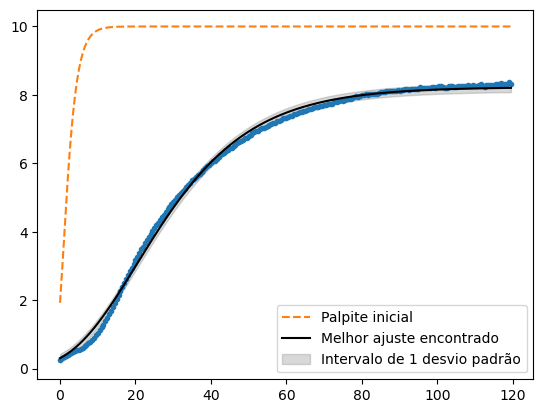

In [18]:
plt.plot(x, y, '.')
plt.plot(x, resultado_fit.init_fit, '--', label='Palpite inicial')
plt.plot(x, resultado_fit.best_fit, '-', color='black', label='Melhor ajuste encontrado')


plt.fill_between(x, resultado_fit.best_fit - desvio_padrao, resultado_fit.best_fit + desvio_padrao,
                    color='gray', alpha=0.3, label='Intervalo de 1 desvio padrão')
plt.legend()
plt.show()

### Denifindo Modelo Linear:

In [19]:
  # Definir a função linear
def linear(t, slope, intercept):
    """Define uma função linear que será usada para o ajuste de dados."""
    return slope * t + intercept

# Criar o modelo linear
linear_model = Model(linear)

log_column = np.log(y)

inicio_intervalo = 20
fim_intervalo = 30

# Filtrar os dados para o intervalo especificado
x_intervalo = x[inicio_intervalo:fim_intervalo+1]
log_column_intervalo = log_column[inicio_intervalo:fim_intervalo+1]

# Definir parâmetros iniciais
params = linear_model.make_params(slope=1, intercept=0)

# Fazer o ajuste apenas no intervalo selecionado
result = linear_model.fit(log_column_intervalo, params, t=x_intervalo)

# Calcular os resíduos
residuos = log_column_intervalo - result.best_fit

# Calcular o desvio padrão dos resíduos
desvio_padrao = np.std(residuos)

# Exibir o relatório do ajuste
print(result.fit_report())

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 11
    # variables        = 2
    chi-square         = 5.9304e-04
    reduced chi-square = 6.5893e-05
    Akaike info crit   = -104.109625
    Bayesian info crit = -103.313834
    R-squared          = 0.99880818
[[Variables]]
    slope:      0.13443445 +/- 0.00154794 (1.15%) (init = 1)
    intercept: -1.29303351 +/- 0.01950341 (1.51%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9921


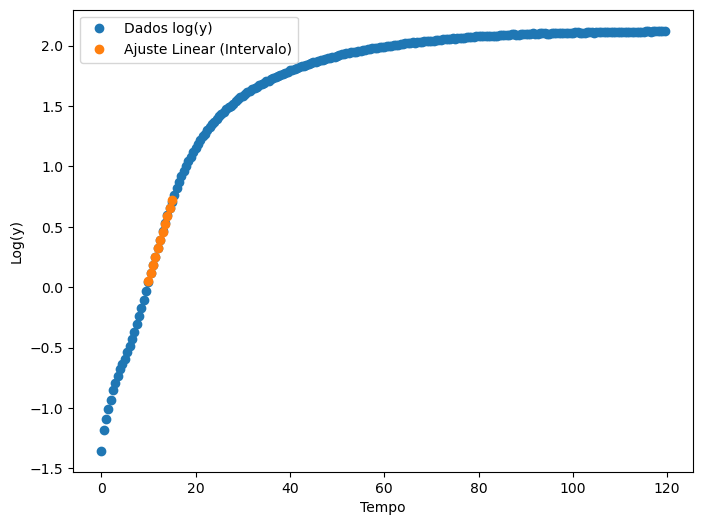

In [20]:
# Plotar o ajuste
plt.figure(figsize=(8,6))
plt.plot(x, log_column, 'o', label='Dados log(y)')
plt.plot(x_intervalo, result.best_fit, 'o', label='Ajuste Linear (Intervalo)')
plt.xlabel('Tempo')
plt.ylabel('Log(y)')
plt.legend()
plt.show()

### Criando Modelo Exponencial:

In [21]:
def exponencial(t, Nmax, k):
    """Função que recebe um tempo(t) e apartir dele e da taxa de crescimento da determinada população ele calcula um valor a partir de uma equação exponencial.
    
    Args:
        t (float): Tempo em unidades de horas.
        Nmax (float): Amplitude do crescimento ou valor assintótico máximo atingido pela função.
        k (float): Taxa de crescimento específica, controlando a rapidez com que o crescimento ocorre após o período de lag.

    Returns:
        float: O valor estimado de uma função Exponencial no tempo "t", representando o crescimento da população microbiana ao longo do tempo.
    """
    
    return Nmax * np.exp(k * t)

In [22]:
# Criando o modelo exponencial com a função definida
modelo_exponencial = Model(exponencial)

# Parâmetros iniciais para o ajuste
params = modelo_exponencial.make_params(Nmax=0, k=0.5)


In [23]:
inicio_intervalo = 4
fim_intervalo = 30

# Filtrar os dados para o intervalo especificado
x_intervalo = x[inicio_intervalo:fim_intervalo+1]
y_intervalo = y[inicio_intervalo:fim_intervalo+1]

# Executando o ajuste com os dados
resultado_fit = modelo_exponencial.fit(y_intervalo, params, t=x_intervalo)

# Exibindo o relatório de ajuste
print(resultado_fit.fit_report())

[[Model]]
    Model(exponencial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 27
    # variables        = 2
    chi-square         = 0.01044372
    reduced chi-square = 4.1775e-04
    Akaike info crit   = -208.154965
    Bayesian info crit = -205.563291
    R-squared          = 0.99840184
[[Variables]]
    Nmax:  0.28293451 +/- 0.00413556 (1.46%) (init = 0)
    k:     0.13189542 +/- 0.00119644 (0.91%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(Nmax, k) = -0.9698


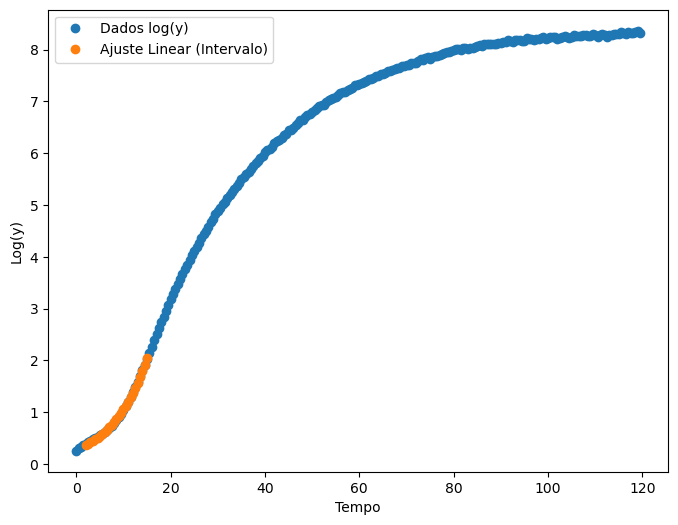

In [24]:

# Plotar o ajuste
plt.figure(figsize=(8,6))
plt.plot(x, y, 'o', label='Dados log(y)')
plt.plot(x_intervalo, resultado_fit.best_fit, 'o', label='Ajuste Linear (Intervalo)')
plt.xlabel('Tempo')
plt.ylabel('Log(y)')
plt.legend()
plt.show()

### Modelo de Zwietering

In [25]:
def zwietering(t, y_0, Nmax, k, tlag):
    """
    Calcula a função modificada de Gompertz para modelar o crescimento microbiano.

    A função de Gompertz é frequentemente usada para descrever o crescimento de populações biológicas, como o crescimento microbiano, com base em parâmetros que controlam a taxa de crescimento, o tempo de atraso (lag) e o valor máximo de crescimento.

    Args:
        t (float): Tempo em unidades de horas.
        y_0 (float): Valor inicial da variável de resposta no tempo zero (t=0).
        A (float): Amplitude do crescimento ou valor assintótico máximo atingido pela função.
        k (float): Taxa de crescimento específica, controlando a rapidez com que o crescimento ocorre após o período de lag.
        tlag (float): Tempo de lag ou atraso, representando o tempo necessário para a adaptação inicial antes do crescimento exponencial.

    Returns:
        float: O valor estimado da função de Gompertz no tempo `t`, representando o crescimento da população microbiana ao longo do tempo.
    """
    return y_0 + ((Nmax - y_0)/(1 + np.exp(((4 * k)/Nmax) * (tlag - t) + 2)))

In [26]:

modelo_zwietering = Model(zwietering)

params = modelo_zwietering.make_params(Nmax=0.1, k=0.1, tlag=0, y_0 = 0)
params['Nmax'].min = 0  # Limite mínimo para Nmax  
params['k'].min = 0.01  # Limite mínimo para k
params['tlag'].min = 0  # Limite mínimo para tlag
params['y_0'].min = 0  # Limite mínimo para tlag
params['y_0'].vary = False  # Fizando y_0



resultado_fit = modelo_zwietering.fit(y, params, t=x)
print(resultado_fit.fit_report())

#desvio_padrao_nmax = resultado_fit.params["Nmax"].stderr

residuos = y - resultado_fit.best_fit

# Calcula o desvio padrão dos resíduos
desvio_padrao = np.std(residuos)

[[Model]]
    Model(zwietering)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 148
    # data points      = 240
    # variables        = 3
    chi-square         = 16.3593940
    reduced chi-square = 0.06902698
    Akaike info crit   = -638.600792
    Bayesian info crit = -628.158875
    R-squared          = 0.98933102
[[Variables]]
    y_0:   0 (fixed)
    Nmax:  8.08267440 +/- 0.02661435 (0.33%) (init = 0.1)
    k:     0.17250326 +/- 0.00285695 (1.66%) (init = 0.1)
    tlag:  3.68864190 +/- 0.43613268 (11.82%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, tlag)    = +0.8909
    C(Nmax, k)    = -0.3183
    C(Nmax, tlag) = -0.2059


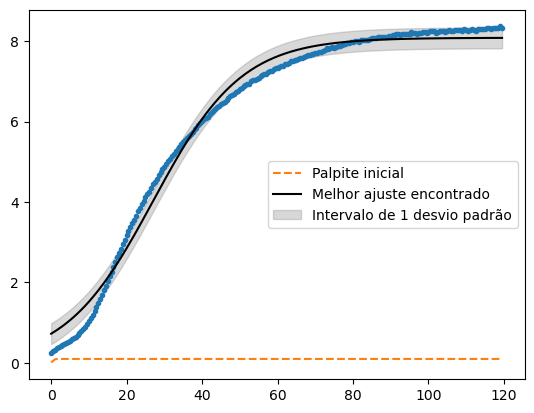

In [27]:
plt.plot(x, y, '.')
plt.plot(x, resultado_fit.init_fit, '--', label='Palpite inicial')
plt.plot(x, resultado_fit.best_fit, '-', color='black', label='Melhor ajuste encontrado')


plt.fill_between(x, resultado_fit.best_fit - desvio_padrao, resultado_fit.best_fit + desvio_padrao,
                    color='gray', alpha=0.3, label='Intervalo de 1 desvio padrão')
plt.legend()
plt.show()

## Criando tabela de parametros iniciais:

### Algumas variáveis:

### Definindo função do Growth Score:

In [28]:
def growth_score(k, Nmax, y_0 = 0):
    """
    Calcula a pontuação de crescimento com base na taxa de crescimento específica (k) e nos valores assintóticos da população.

    Args:
    k (float): Taxa de crescimento específica. Representa a rapidez com que a população de micro-organismos cresce.
    Nmax (float): Valor assintótico máximo da população de micro-organismos. Representa a capacidade máxima de crescimento.
    y_0 (float): Valor inicial da população de micro-organismos.

    Returns:
    float: Pontuação de crescimento, calculada como a diferença entre o valor máximo e o valor inicial da população acrescida de 25% da taxa de crescimento.
    """
    return (Nmax - y_0) + 0.25*k

### Função que Cria Tabela:

In [29]:
def gerar_tabela(dici_final, modelo_escolhido = "Gompertz", ini_log = 0, fim_log = 0):

    if modelo_escolhido == "Gompertz":
        
        tabela = {
                    "Placa": [],
                    "Poços": [],
                    "μMax": [],
                    "A": [],
                    "Fase lag": [],
                    "Growth Score": [],

                }
        
        for placa in dici_final:
            for poço in dici_final[placa]:
                
                x = dici_final[placa][poços]["Tempo(horas)"]
                y = dici_final[placa][poços]["y_experimental"]
                
                modelo_gompertz = Model(fn.gompertz)

                params = modelo_gompertz.make_params(Nmax=10, k=0.5, tlag=1)
                params['Nmax'].min = 0  # Limite mínimo para A
                params['k'].min = 0.01  # Limite mínimo para μMax
                params['tlag'].min = 0  # Limite mínimo para tlag

                resultado_fit = modelo_gompertz.fit(y, params, t=x)

                GS = growth_score(resultado_fit.params["k"].value,resultado_fit.params["Nmax"].value)

                tabela["Placa"].append(placa)
                tabela["Poços"].append(poço)
                tabela['μMax'].append(resultado_fit.params["k"].value)
                tabela['A'].append(resultado_fit.params["Nmax"].value)
                tabela["Fase lag"].append(resultado_fit.params["tlag"].value)
                tabela["Growth Score"].append(GS)
        
        return tabela
                



    if modelo_escolhido == "Zwietering":

        tabela = {
                    "Placa": [],
                    "Poços": [],
                    "Taxa Crescimento": [],
                    "Nmax": [],
                    "Tempo lag": [],
                    "Growth Score": [],
                }
        
    if modelo_escolhido == "Linear":
         
         tabela = {
                    "Placa": [],
                    "Poços": [],
                    "Taxa Crescimento": [],
                    "Nmax": [],
                    "Tempo lag": [],
                    "Growth Score": [],
                }

    

## Iniciando trabalhos com gráficos:

### Função modela_selecionados:

In [30]:
def modela_selecionados(df_final,df_selecinados, modelo, tlag = "auto"):
    
    df_grafico = pd.DataFrame()


    primeira_placa = next(iter(df_final.values()))  # Obtém o primeiro item do dicionário "dici"
    primeiro_poco = next(iter(primeira_placa.values()))  # Obtém o primeiro item do dicionário dentro da placa 


    # Acessando a primeira coluna do dataset (primeiro poço)
    primeira_coluna = primeiro_poco.iloc[:, 0]  # Seleciona a primeira coluna usando iloc

    df_grafico["Tempo(horas)"] = primeira_coluna

    if modelo == "Gompertz":

        for i in range(len(df_selecinados["Placa"])):
            placa = df_selecinados["Placa"][i]
            poços = df_selecinados["Poços"][i]

            y = df_final[placa][poços]["y_experimental"]

            df_grafico[poços] = y
        

        return df_grafico
            

In [31]:
dici = {
    "Poço-A(1-3)": pd.DataFrame({
        'coluna1': [1, 2, 3],
        'coluna2': [4, 5, 6]
    })
}

# Dados para a nova coluna y_gompertz
y_gompertz = [7, 8, 9]

# Adicionando a nova coluna
dici["Poço-A(1-3)"]["y_gompertz"] = y_gompertz

# Verificando o resultado
print(dici["Poço-A(1-3)"])

   coluna1  coluna2  y_gompertz
0        1        4           7
1        2        5           8
2        3        6           9


### Teste:

In [32]:
def filtra_dataset(df, dici_selecionados):
    """
    Filtra o dicionário original com base nas placas e poços selecionados.

    Args:
        df (dict): Dicionário contendo o dataset original.
        dici_selecionados (dict): Dicionário com placas e poços selecionados.

    Returns:
        dict: Novo dicionário com os dados filtrados.
    """
    # Inicializa o dicionário filtrado
    df_filtrado = {}

    # Itera sobre as placas selecionadas
    for placa in dici_selecionados['Placa']:
        if placa in df:  # Verifica se a placa está no dicionário original
            df_filtrado[placa] = {}
            # Itera sobre os poços selecionados
            for poco in dici_selecionados['Poços']:
                if poco in df[placa]:  # Verifica se o poço está na placa
                    # Adiciona o poço e seus dados ao novo dicionário
                    df_filtrado[placa][poco] = df[placa][poco]
    
    return df_filtrado

# Exemplo de uso:
df = {
    'Placa_1': {
        'Poço-A(1-3)': {'Tempo(horas)': [0, 1, 2], 'y_esperimental': [0.5, 0.6, 0.7], 'y_previsto': [0.4, 0.5, 0.6]},
        'Poço-B(4-6)': {'Tempo(horas)': [0, 1, 2], 'y_esperimental': [1.5, 1.6, 1.7], 'y_previsto': [1.4, 1.5, 1.6]}
    },
    'Placa_2': {
        'Poço-C(1-3)': {'Tempo(horas)': [0, 1, 2], 'y_esperimental': [2.5, 2.6, 2.7], 'y_previsto': [2.4, 2.5, 2.6]},
        'Poço-D(4-6)': {'Tempo(horas)': [0, 1, 2], 'y_esperimental': [3.5, 3.6, 3.7], 'y_previsto': [3.4, 3.5, 3.6]}
    }
}

dici_selecionados = {
    'Placa': ["Placa_1", "Placa_2"],
    'Poços': ["Poço-A(1-3)", "Poço-D(4-6)"]
}

df_filtrado = filtra_dataset(df, dici_selecionados)
print(df_filtrado)

{'Placa_1': {'Poço-A(1-3)': {'Tempo(horas)': [0, 1, 2], 'y_esperimental': [0.5, 0.6, 0.7], 'y_previsto': [0.4, 0.5, 0.6]}}, 'Placa_2': {'Poço-D(4-6)': {'Tempo(horas)': [0, 1, 2], 'y_esperimental': [3.5, 3.6, 3.7], 'y_previsto': [3.4, 3.5, 3.6]}}}


### Gera os 3 gráficos:

In [33]:
def gera_tres_gráficos(df_comtriplicatas, df_selecionados):

    for i in range(len(df_selecionados["Placa"])):
        placa = df_selecionados["Placa"][i]
        poços = df_selecionados["Poços"][i]

        x = df_comtriplicatas[placa][poços]["Tempo(horas)"]

        for coluna in df_comtriplicatas[placa][poços].columns[1:]:
            # Seleciona todas as linhas da coluna atual, ignorando a primeira coluna
            y = df_comtriplicatas[placa][poços][coluna]
            print(y)


In [34]:
df_comtriplicatas, teste = fn.arquivos_to_placas([dataset_exemplo])

In [35]:
df_teste= {
    "Placa": ["Placa_1","Placa_1"],
    "Poços": ["Poço_A(1-3)", "Poço_B(4-6)"]
}

In [36]:
gera_tres_gráficos(df_comtriplicatas, df_teste)

0      0.318
1      0.376
2      0.407
3      0.443
4      0.484
       ...  
235    8.612
236    8.578
237    8.576
238    8.627
239    8.623
Name: Poço_A(1), Length: 240, dtype: float64
0      0.212
1      0.249
2      0.269
3      0.292
4      0.315
       ...  
235    7.796
236    7.799
237    7.821
238    7.811
239    7.843
Name: Poço_A(2), Length: 240, dtype: float64
0      0.244
1      0.297
2      0.327
3      0.355
4      0.384
       ...  
235    8.544
236    8.607
237    8.594
238    8.652
239    8.518
Name: Poço_A(3), Length: 240, dtype: float64
0      0.203
1      0.248
2      0.266
3      0.286
4      0.312
       ...  
235    7.630
236    7.615
237    7.651
238    7.667
239    7.659
Name: Poço_B(4), Length: 240, dtype: float64
0      0.184
1      0.229
2      0.240
3      0.263
4      0.288
       ...  
235    8.411
236    8.361
237    8.378
238    8.447
239    8.377
Name: Poço_B(5), Length: 240, dtype: float64
0      0.180
1      0.221
2      0.238
3      0.259
4      0

## Plotando mais de um gráfico por vez

In [37]:
def modelo_escolhido(modelo,tabela, i):

    # Função que define o modelo de tabela caso a tabela estaja vazia:
    def gerar_tabela(modelo):
        if modelo == "Linear":
            tabela = {
                'Poços': [],
                "STD_da_Curva": [],
                "Slope": [],
                'Intercept': []
            }
            return tabela

        if modelo == "Gompertz":
            tabela = {
                'Poços': [],
                "STD_da_Curva": [],
                'Nmax': [],
                'K': [],
                'T-lag': []
            }
            return tabela

        if modelo == "Exponencial":
            tabela = {
                'Poços': [],
                "STD": [],
                "Slope": [],
                'Intercept': []
            }
            return tabela



    if not bool(tabela): # Se a tabela estiver vazía.
        tabela = gerar_tabela(modelo) # Gera uma tabela utilizando o modelo escolhido

    # Adiciona os parametros otimizados para cada amostra no dicionario definido anteriormente. 
    tabela['Poços'].append(i)
    tabela['STD_da_Curva'].append(desvio_padrao)
    tabela['Nmax'].append(resultado_fit.params["Nmax"].value)
    tabela['K'].append(resultado_fit.params["k"].value)
    tabela["T-lag"].append(resultado_fit.params["tlag"].value)
    
    return tabela



    tabela['Poços'].append(i)
    tabela['STD_da_Curva'].append(desvio_padrao)
    tabela['Slope'].append(resultado_fit.params["Nmax"].value)
    tabela['Intercep'].append(resultado_fit.params["I"].value)



    return tabela 
    
    
    

### Função plote definitivo:

In [38]:
def plot_dataset(df,titulo,legenda_x, legenda_y):
    """
    Plota um gráfico onde a primeira coluna do DataFrame é o eixo X e as demais são Y sobrepostos.
    :param df: DataFrame contendo os dados a serem plotados.
    """
    # Criando a figura
    fig, ax = plt.subplots()

    # A primeira coluna é o eixo X
    eixo_x = df.iloc[:, 0]
    
    # As demais colunas serão plotadas como diferentes séries no eixo Y
    for i in range(1, df.shape[1]):
        ax.plot(eixo_x, df.iloc[:, i], label=df.columns[i])
    
    # Configurações de exibição
    ax.set_xlabel(legenda_x)  # Nome da primeira coluna como rótulo do eixo X
    ax.set_ylabel(legenda_y)
    ax.set_title(titulo)
    ax.legend()
    ax.grid(True)
    
    # Usando o st.pyplot() para exibir o gráfico no Streamlit
    st.pyplot(fig)

In [39]:
amostras = ["Poço-A(4-6)","Poço-C(10-12)","Poço-A(1-3)","Poço-D(1-3)","Poço-B(10-12)"]  # Definindo os poços que serão usados e comparados. 

modelo_gompertz = Model(gompertz_2) # Definindo qual modelo será usado. 

params = modelo_gompertz.make_params(Nmax=10, k=0.5, tlag=1) #Definindo Parametros iniciais do modelo
params['Nmax'].min = 0  # Limite mínimo para Nmax
params['k'].min = 0.01  # Limite mínimo para k
params['tlag'].min = 0  # Limite mínimo para tlag


#linear_model = Model(linear)

# Definir parâmetros iniciais
#params = linear_model.make_params(slope=1, intercept=0)



# Definindo o dicinionário que vai receber parametros otimizados e que posteriormente irão para uma tabela.
tabela = {
    'Poços': [],
    "STD_da_Curva": [],
    'Nmax': [],
    'K': [],
    'T-lag': []
}




for i in amostras: #Itera cada uma das amostras selecionadas
    
    x = dici_final[placa][poços][dici_final[placa][poços].columns[0]]
    y = dici_final[placa][poços][dici_final[placa][poços].columns[1]]

    resultado_fit = modelo_gompertz.fit(y, params, t=x)

    residuos = y - resultado_fit.best_fit

    # Calcula o desvio padrão dos resíduos
    desvio_padrao = np.std(residuos)


    #print(resultado_fit.fit_report())

    # Adiciona os parametros otimizados para cada amostra no dicionario definido anteriormente. 
    tabela['Poços'].append(i)
    tabela['STD_da_Curva'].append(desvio_padrao)
    tabela['Nmax'].append(resultado_fit.params["Nmax"].value)
    tabela['K'].append(resultado_fit.params["k"].value)
    tabela["T-lag"].append(resultado_fit.params["tlag"].value)




    # Criar o gráfico de pontos
    plt.plot(x, y, '.')

    # Plotar a linha do melhor ajuste
    plt.plot(x, resultado_fit.best_fit, '-', label=f"Melhor ajuste encontrado para {i}")


    plt.fill_between(x, resultado_fit.best_fit - desvio_padrao, resultado_fit.best_fit + desvio_padrao,
                    color='gray', alpha=0.3)

    # Adicionar legenda
    plt.legend()

    

#plt.figure(figsize=(10, 6))  # Aumenta o tamanho do gráfico (10 de largura e 6 de altura)

# Adicionar títulos e legendas aos eixos
plt.title("Gráfico de Crescimento Microbiano")
plt.xlabel("Tempo(horas)")  # Substitua pelo nome desejado
plt.ylabel("Green Value")  # Substitua pelo nome desejado  


plt.show()

parametros = pd.DataFrame(tabela)
print(parametros)


NameError: name 'gompertz_2' is not defined

In [ ]:
resultado_fit.params['Nmax'].stderr


0.01540595917981946

In [ ]:
def teste():

    return 10, 15

In [ ]:
x = teste()[1]

# Referencias:

[1] https://en.wikipedia.org/wiki/Gompertz_function  
[2] Notebooks sobre modelagem de dados disponibilizados pelos professores Daniel Roberto Cassar e James Moraes de Almeida 